In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from nltk.corpus import stopwords
from collections import Counter
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as tarnform
import spacy
import re


In [2]:
data_location = '../input/flickr8k/'
df = pd.read_csv("../input/flickr8k/captions.txt")
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


../input/flickr8k//Images/1003163366_44323f5815.jpg


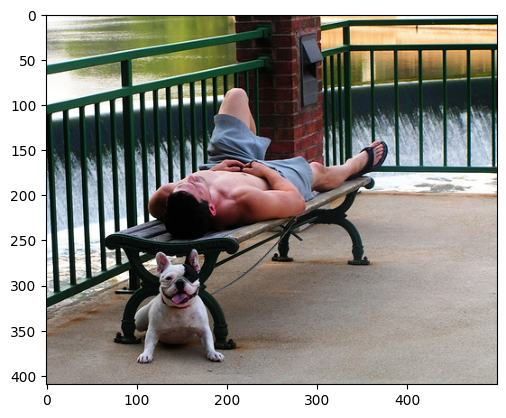

In [3]:
data_idx = 19
image_path = data_location+"/Images/"+df.iloc[data_idx,0]
print(image_path)

img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()





In [4]:
spacy_eng = spacy.load('en_core_web_sm')
text = 'This is a good place for study'
[token.text.lower() for token in spacy_eng.tokenizer(text)]
for token in spacy_eng(text):
    print(token)


This
is
a
good
place
for
study


In [5]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s